# U-Net Audio Denoising Model

This is the script used to train the U-Net denoising model.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, Activation
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Load Spectrograms

In [3]:
def load_spectrograms_into_matrix(directory, print_paths=False):
    # Resolve the absolute path of the directory to handle relative paths correctly
    abs_directory = os.path.abspath(directory)
    data_matrix = []
    file_paths = []  # Store file paths for verification

    # Walk through the directory structure
    for root, dirs, files in sorted(os.walk(abs_directory)):
        dirs.sort()  # Sort directories to maintain consistent order
        files.sort()  # Sort files to ensure consistent ordering within the same directory
        for file in files:
            if file.endswith('.npy'):
                # Generate the full path to the file
                file_path = os.path.join(root, file)
                # Optionally print file paths for verification
                if print_paths:
                    print(file_path)
                # Load the spectrogram
                spectrogram = np.load(file_path)
                # Append the spectrogram and file path to their respective lists
                data_matrix.append(spectrogram)
                file_paths.append(file_path)

    # Convert list to a numpy array for easier manipulation later
    data_matrix = np.array(data_matrix)
    return data_matrix, file_paths

def verify_alignment(noisy_paths, clean_paths):
    # Verify that each path in the noisy_paths corresponds correctly to the path in the clean_paths
    misalignments = []
    for noisy, clean in zip(noisy_paths, clean_paths):
        if os.path.splitext(noisy.split('/')[-1])[0] != os.path.splitext(clean.split('/')[-1])[0]:
            misalignments.append((noisy, clean))

    if misalignments:
        print("Misaligned files:")
        for mis in misalignments:
            print(mis)
    else:
        print("All files are correctly aligned.")

# Define relative paths to the noisy and clean directories using the 'count' variable
count = 1  # User can change this as needed
noisy_directory = f'../../dataset/iteration-{count}/data/mixed/spectrogram-256-frames/flute'
clean_directory = f'../../dataset/iteration-{count}/data/clean/spectrogram-256-frames/flute'

# Load data and file paths, resolving paths absolutely
X_noisy, noisy_paths = load_spectrograms_into_matrix(noisy_directory, print_paths=False)
Y_clean, clean_paths = load_spectrograms_into_matrix(clean_directory, print_paths=False)

# Verify alignment of X and Y matrix, i.e. that the i-th clean spectrogram corresponds to the i-th mixed spectrogram
verify_alignment(noisy_paths, clean_paths)

# Example of how to use the data
print(f"Shape of noisy data matrix: {X_noisy.shape}")
print(f"Shape of clean data matrix: {Y_clean.shape}")

All files are correctly aligned.
Shape of noisy data matrix: (1368, 1024, 256, 2)
Shape of clean data matrix: (1368, 1024, 256, 2)


# Define and instantiate model

In [7]:
def unet_model(input_size=(1024, 256, 2)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(2, (1, 1), activation='linear')(c9)  # 2 channels for magnitude and phase

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
unet = unet_model()
unet.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024, 256, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 1024, 256, │      1,216 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 1024, 256, │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 512, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 512, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 512, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 256, 64,   │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 64,   │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 64,   │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 32,   │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 32,   │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 32,   │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 32,   │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 32,   │          0 │ conv2d_transpose

 Total params: 31,031,234 (118.37 MB)

 Trainable params: 31,031,234 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Split data into training + validation set and a separate test set
X_train, X_test, Y_train, Y_test = train_test_split(X_noisy, Y_clean, test_size=0.1, random_state=42)

# Train the model
history = unet.fit(X_train, Y_train, batch_size=4, epochs=2, validation_split=0.2)

# Evaluate the model on the test set
test_loss = unet.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)


Epoch 1/2
246/246 ━━━━━━━━━━━━━━━━━━━━ 4800s 19s/step - loss: 1.5547 - mean_squared_error: 1.5547 - val_loss: 0.1967 - val_mean_squared_error: 0.1967
Epoch 2/2
246/246 ━━━━━━━━━━━━━━━━━━━━ 4699s 19s/step - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 0.1861 - val_mean_squared_error: 0.1861
5/5 ━━━━━━━━━━━━━━━━━━━━ 173s 33s/step - loss: 0.1968 - mean_squared_error: 0.1968
Test Loss: [0.2000971883535385, 0.2000971883535385]


In [9]:
# denoised_spectrograms = model.predict(X_noisy, batch_size=4)

denoised_spectrograms = unet.predict(X_noisy, batch_size=4)
# print(denoised_spectrograms[0])  # Print the first denoised spectrogram to check



342/342 ━━━━━━━━━━━━━━━━━━━━ 1761s 5s/step


In [13]:
# Assuming 'denoised_spectrograms' is your array of spectrograms after prediction
# and 'noisy_paths' contains the full file paths to the original noisy spectrograms.

for i, denoised_spectrogram in enumerate(denoised_spectrograms):
    # The original file path
    original_path = noisy_paths[i]
    
    # Strip off the original directory and extension, then append '_denoised.npy'
    new_filename = os.path.splitext(os.path.basename(original_path))[0] + '.npy'
    
    # You may want to save in a new directory, so construct the path as needed
    save_directory = '/Users/Leo/Developer/Local/senior-project/dataset/iteration-1/data/output/spectrogram-256-frames'
    save_path = os.path.join(save_directory, new_filename)
    
    # Save the denoised spectrogram
    np.save(save_path, denoised_spectrogram)


In [12]:
import os
import shutil

def ensure_dir(directory):
    """ Ensure that a directory exists; if not, create it. """
    if not os.path.exists(directory):
        os.makedirs(directory)

# Input directory containing .numpy files
base_directory = '/Users/Leo/Developer/Local/senior-project/dataset/iteration-1/data/output/spectrogram-256-frames'

# Instrument directories
instruments = ['flute']

# First pass: Move files based on substring matches
for file in os.listdir(base_directory):
    if file.endswith('.npy'):
        file_path = os.path.join(base_directory, file)
        for instrument in instruments:
            if instrument in file:
                subdir_path = os.path.join(base_directory, instrument)
                ensure_dir(subdir_path)
                shutil.move(file_path, os.path.join(subdir_path, file))
                break  # Assuming one substring match per file

# Second pass: Move files based on the part of the filename after the first underscore
for instrument in instruments:
    subdir_path = os.path.join(base_directory, instrument)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            # Find part of the filename after the first underscore
            part_after_underscore = file.split('_', 1)[1] if '_' in file else file
            new_dir_name = part_after_underscore.rsplit('.', 1)[0]  # Remove extension
            new_dir_path = os.path.join(subdir_path, new_dir_name)
            ensure_dir(new_dir_path)
            file_path = os.path.join(subdir_path, file)
            shutil.move(file_path, os.path.join(new_dir_path, file))

print("Files have been organized.")


Files have been organized.


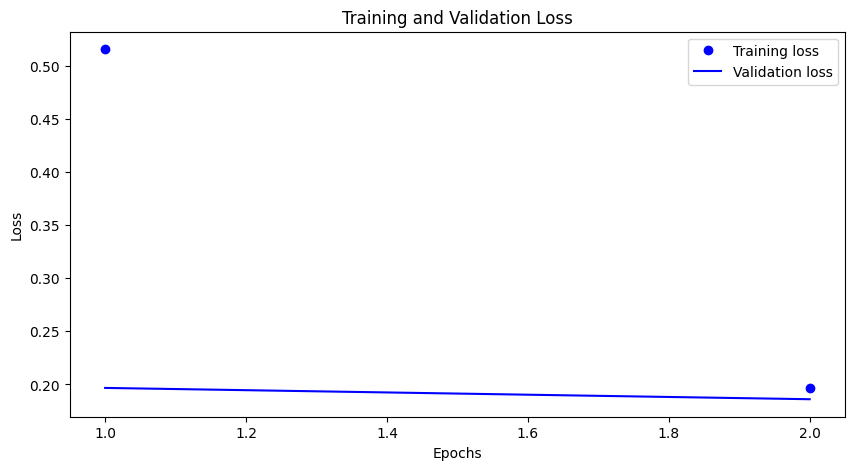

In [17]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit method
# For example:
# history = model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=4)

# Extract the history data
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' is for "blue line"
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
